In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, classification_report
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

import pickle

# Read the dataset

In [2]:
df = pd.read_csv('datasets/cleaned_datasets/cleaned-service-data.csv')
df.head()

,review,label
0,layan ramah air panas shower baik,pos
1,staff ramah lokasi harga mahal fasilitas minim...,pos
2,kamar luas staff ramah sarap enak air kamar ma...,pos
3,layan bagus ramah ac dingin channel tv lengkap,pos
4,layan kondisi kamar tolong perhati kamar mandi...,pos


# Split dataset 

In [3]:
X = df['review']
y = df['label']
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (298,)
y shape: (298,)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['label'], test_size=0.2, random_state=42)

# Menampilkan hasil
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (238,)
X_test shape: (60,)
y_train shape: (238,)
y_test shape: (60,)


# TF-IDF 

In [5]:
# Inisialisasi objek stopword remover
stopword_factory = StopWordRemoverFactory()
stopwords = stopword_factory.get_stop_words()

# tf_idf model
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=stopwords)

# menghitung nilai tf-idf
tfidf_matrix = tfidf_vectorizer.fit_transform(X)

# Menampilkan hasil
print(tfidf_matrix.shape)


(298, 2524)


In [6]:
tfidf_split = TfidfVectorizer(ngram_range=(1,2), stop_words=stopwords)

# menghitung nilai tf-idf
train_tfidf_matrix = tfidf_split.fit_transform(X_train)
test_tfidf_matrix = tfidf_split.transform(X_test)

# Menampilkan hasil
print(train_tfidf_matrix.shape)
print(test_tfidf_matrix.shape)

(238, 2018)
(60, 2018)


In [7]:
with open('trained_model/tfidf_service_model.pkl', 'wb') as f:
    pickle.dump(tfidf_split, f)

# Smote

In [8]:
y.value_counts()

label
pos    149
neg    149
Name: count, dtype: int64

In [9]:
# Train
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(tfidf_matrix, y)

# Menampilkan hasil
print("X_resampled shape:", X_resampled.shape)
print("y_resampled shape:", y_resampled.shape)

X_resampled shape: (298, 2524)
y_resampled shape: (298,)


In [10]:
# Train
X_train_resampled, y_train_resampled = SMOTE(random_state=42).fit_resample(train_tfidf_matrix, y_train)
X_test_resampled, y_test_resampled = SMOTE(random_state=42).fit_resample(test_tfidf_matrix, y_test)

# Menampilkan hasil
print("X_train_resampled shape:", X_train_resampled.shape)
print("X_test_resampled shape:", X_test_resampled.shape)
print("y_train y_train_resampled:", y_train_resampled.shape)
print("y_test_resampled shape:", y_test_resampled.shape)

X_train_resampled shape: (246, 2018)
X_test_resampled shape: (68, 2018)
y_train y_train_resampled: (246,)
y_test_resampled shape: (68,)


# Naive Bayes

In [11]:
# parameter tuning
param_grid = {'alpha': [0.1, 0.5, 1.0, 1.5]}
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=10)
grid_search.fit(X_resampled, y_resampled)

# Mendapatkan parameter terbaik
best_alpha = grid_search.best_params_['alpha']
best_score = grid_search.best_score_
cv_results = grid_search.cv_results_

# Convert cv_results to DataFrame
cv_results_df = pd.DataFrame(cv_results)

# Hanya tampilkan kolom yang relevan
relevant_columns = ['param_alpha', 'mean_test_score', 'std_test_score', 'rank_test_score']
cv_results_df = cv_results_df[relevant_columns]

# Tampilkan hasil secara terurut berdasarkan mean_test_score
cv_results_df = cv_results_df.sort_values(by='mean_test_score', ascending=False)

# Tampilkan hasil
print("Grid Search Results:")
print(cv_results_df)

print(f"best_alpha, {best_alpha}")
print(f"best_score, {best_score}")

Grid Search Results:
  param_alpha  mean_test_score  std_test_score  rank_test_score
0         0.1         0.751609        0.063810                1
2         1.0         0.731724        0.062599                2
1         0.5         0.725057        0.056307                3
3         1.5         0.725057        0.054442                3
best_alpha, 0.1
best_score, 0.7516091954022989


In [12]:
nb = MultinomialNB(alpha=best_alpha)
k_fold = KFold(n_splits=10, shuffle=True, random_state=42)

accuracy_scores = cross_val_score(nb, X_resampled, y_resampled, cv=k_fold, scoring='accuracy')
precision_scores = cross_val_score(nb, X_resampled, y_resampled, cv=k_fold, scoring='precision_weighted')
recall_scores = cross_val_score(nb, X_resampled, y_resampled, cv=k_fold, scoring='recall_weighted')
f1_scores = cross_val_score(nb, X_resampled, y_resampled, cv=k_fold, scoring='f1_weighted')

print('Cross-Validation Accuracy Score:', accuracy_scores.mean())
print('Cross-Validation Precision Score:', precision_scores.mean())
print('Cross-Validation Recall Score:', recall_scores.mean())
print('Cross-Validation F1 Score:', f1_scores.mean())

Cross-Validation Accuracy Score: 0.7485057471264368
Cross-Validation Precision Score: 0.7675517025529304
Cross-Validation Recall Score: 0.7485057471264368
Cross-Validation F1 Score: 0.7450296634667857


In [13]:
nb = MultinomialNB(alpha=best_alpha)
nb.fit(X_train_resampled, y_train_resampled)

y_pred = nb.predict(X_test_resampled)

print('Accuracy score : ', accuracy_score(y_test_resampled, y_pred))
print('Precision score : ', precision_score(y_test_resampled, y_pred, average='weighted'))
print('Recall score : ', recall_score(y_test_resampled, y_pred, average='weighted'))
print('F1 score : ', f1_score(y_test_resampled, y_pred, average='weighted'))

Accuracy score :  0.6323529411764706
Precision score :  0.6423255813953488
Recall score :  0.6323529411764706
F1 score :  0.6257979308826767


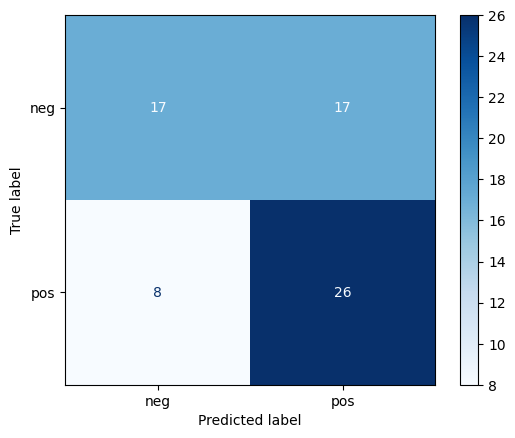

In [14]:
ConfusionMatrixDisplay.from_predictions(y_test_resampled, y_pred, cmap='Blues')
plt.show()

In [15]:
print(classification_report(y_test_resampled, y_pred))

              precision    recall  f1-score   support

         neg       0.68      0.50      0.58        34
         pos       0.60      0.76      0.68        34

    accuracy                           0.63        68
   macro avg       0.64      0.63      0.63        68
weighted avg       0.64      0.63      0.63        68



In [16]:
with open('trained_model/nb_classifier_service.pkl', 'wb') as f:
    pickle.dump(nb, f)